In [ ]:
from google.colab import files

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import TargetEncoder, RobustScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, median_absolute_error
import matplotlib.pyplot as plt
arquivo = files.upload()


# 1. Carregar os dados
df = pd.read_csv('/content/Social Media Engagement Dataset.csv')  # Substitua pelo caminho do arquivo



In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   post_id                  12000 non-null  object 
 1   timestamp                12000 non-null  object 
 2   day_of_week              12000 non-null  object 
 3   platform                 12000 non-null  object 
 4   user_id                  12000 non-null  object 
 5   location                 12000 non-null  object 
 6   language                 12000 non-null  object 
 7   text_content             12000 non-null  object 
 8   hashtags                 12000 non-null  object 
 9   mentions                 8059 non-null   object 
 10  keywords                 12000 non-null  object 
 11  topic_category           12000 non-null  object 
 12  sentiment_score          12000 non-null  float64
 13  sentiment_label          12000 non-null  object 
 14  emotion_type          

In [ ]:
missing = df.isnull().sum().sort_values(ascending=False)
print(missing[missing > 0])

mentions    3941
dtype: int64


In [ ]:
print(df.describe().T)

                           count          mean           std        min  \
sentiment_score          12000.0      0.000553      0.583563   -0.99980   
toxicity_score           12000.0      0.503868      0.288198    0.00000   
likes_count              12000.0   2490.720250   1441.532530    0.00000   
shares_count             12000.0   1007.167167    575.072282    0.00000   
comments_count           12000.0    504.345750    288.684160    0.00000   
impressions              12000.0  49811.338500  28930.289451  130.00000   
engagement_rate          12000.0      0.278137      1.149206    0.00188   
user_past_sentiment_avg  12000.0      0.001472      0.576627   -0.99960   
user_engagement_growth   12000.0      0.000998      0.289940   -0.49990   
buzz_change_rate         12000.0      0.729692     57.787219  -99.90000   

                                  25%           50%           75%          max  
sentiment_score             -0.503200     -0.006200      0.513525      0.99990  
toxicity_sco

In [ ]:
# Ver a distribuição da plataforma
print(df['platform'].value_counts())

# Ver a distribuição por dia da semana
print(df['day_of_week'].value_counts())

platform
YouTube      2436
Facebook     2431
Twitter      2406
Reddit       2372
Instagram    2355
Name: count, dtype: int64
day_of_week
Wednesday    1771
Friday       1723
Monday       1720
Thursday     1718
Sunday       1716
Tuesday      1677
Saturday     1675
Name: count, dtype: int64


In [ ]:
categorical_cols = ['day_of_week', 'platform', 'language', 'topic_category', 'sentiment_label', 'brand_name', 'campaign_phase']
df_encoded = pd.get_dummies(df, columns=categorical_cols)

<Axes: >

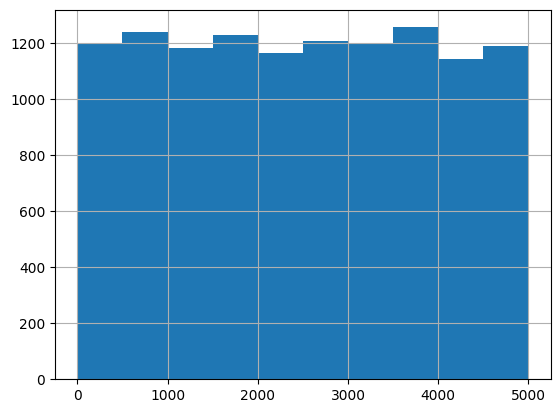

In [ ]:
df['likes_count'].hist()

<Axes: xlabel='platform'>

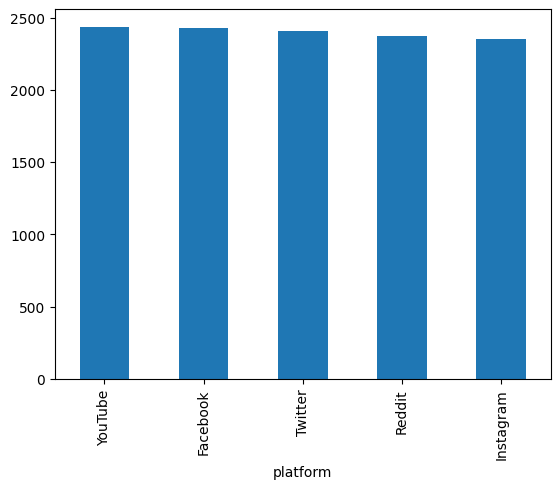

In [ ]:
df['platform'].value_counts().plot(kind='bar')

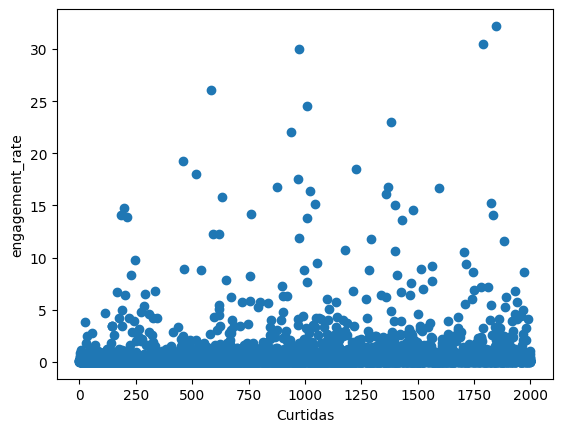

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(df['shares_count'], df['engagement_rate'])
plt.xlabel('Curtidas')
plt.ylabel('engagement_rate')
plt.show()

In [ ]:
df.head()

,post_id,timestamp,day_of_week,platform,user_id,location,language,text_content,hashtags,mentions,...,comments_count,impressions,engagement_rate,brand_name,product_name,campaign_name,campaign_phase,user_past_sentiment_avg,user_engagement_growth,buzz_change_rate
0,kcqbs6hxybia,2024-12-09 11:26:15,Monday,Instagram,user_52nwb0a6,"Melbourne, Australia",pt,Just tried the Chromebook from Google. Best pu...,#Food,NaN,...,701,18991,0.19319,Google,Chromebook,BlackFriday,Launch,0.0953,-0.3672,19.1
1,vkmervg4ioos,2024-07-28 19:59:26,Sunday,Twitter,user_ucryct98,"Tokyo, Japan",ru,Just saw an ad for Microsoft Surface Laptop du...,"#MustHave, #Food","@CustomerService, @BrandCEO",...,359,52764,0.05086,Microsoft,Surface Laptop,PowerRelease,Post-Launch,0.1369,-0.4510,-42.6
2,memhx4o1x6yu,2024-11-23 14:00:12,Saturday,Reddit,user_7rrev126,"Beijing, China",ru,What's your opinion about Nike's Epic React? ...,"#Promo, #Food, #Trending",NaN,...,643,8887,0.45425,Nike,Epic React,BlackFriday,Post-Launch,0.2855,-0.4112,17.4
3,bhyo6piijqt9,2024-09-16 04:35:25,Monday,YouTube,user_4mxuq0ax,"Lagos, Nigeria",en,Bummed out with my new Diet Pepsi from Pepsi! ...,"#Reviews, #Sustainable","@StyleGuide, @BrandSupport",...,743,6696,0.42293,Pepsi,Diet Pepsi,LaunchWave,Launch,-0.2094,-0.0167,-5.5
4,c9dkiomowakt,2024-09-05 21:03:01,Thursday,Twitter,user_l1vpox2k,"Berlin, Germany",hi,Just tried the Corolla from Toyota. Absolutely...,"#Health, #Travel","@BrandSupport, @InfluencerName",...,703,47315,0.08773,Toyota,Corolla,LocalTouchpoints,Launch,0.6867,0.0807,38.8


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=500) # Limita para as 500 palavras mais importantes
text_features = tfidf.fit_transform(df['text_content'])

In [ ]:
import pandas  as pd
import numpy   as np
import xgboost as xgb

X = df[['likes_count', 'shares_count', 'comments_count', 'impressions',
        'sentiment_score', 'toxicity_score', 'user_past_sentiment_avg',
        'user_engagement_growth']]

y = df['engagement_rate']

regressor=xgb.XGBRegressor(eval_metric='rmsle')

from sklearn.model_selection import GridSearchCV
# set up our search grid
param_grid = {"max_depth":    [4, 5, 6],
              "n_estimators": [400, 500, 600],
              "learning_rate": [0.01, 0.015]}


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# try out every combination of the above values
search = GridSearchCV(regressor, param_grid, cv=5).fit(X_train, y_train)

print("The best hyperparameters are ",search.best_params_)


regressor=xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = search.best_params_["max_depth"],
                           eval_metric='rmsle')

regressor.fit(X_train, y_train)

The best hyperparameters are  {'learning_rate': 0.015, 'max_depth': 6, 'n_estimators': 600}


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmsle', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.015, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=600, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
predictions = regressor.predict(X_test)

MSE:   0.1413
RMSE:  0.3759
R²:    0.8881
RMSLE: 0.0308


,y_true,y_pred,residuo,erro_rel
1935,0.10062,0.101169,-0.000549,-0.005460
6494,0.12714,0.136626,-0.009486,-0.074610
1720,4.39035,3.658411,0.731939,0.166715
9120,0.04179,0.039058,0.002732,0.065375
360,0.04875,0.051835,-0.003085,-0.063289


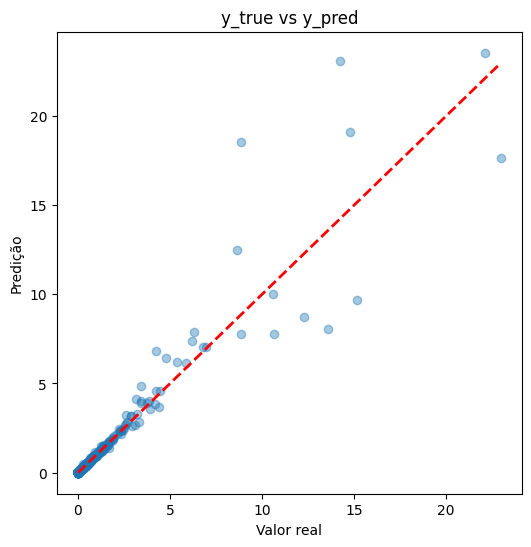

<Figure size 800x500 with 0 Axes>

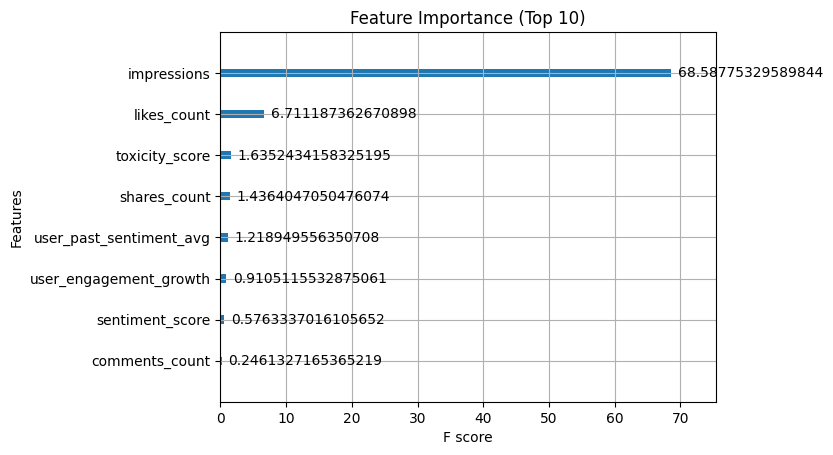

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_log_error

# 1) Gera predições
y_pred = regressor.predict(X_test)

# 2) Métricas de regressão
mse   = mean_squared_error(y_test, y_pred)
rmse  = np.sqrt(mse)
r2    = r2_score(y_test, y_pred)
rmsle = np.sqrt(mean_squared_log_error(y_test.clip(0),
                                       y_pred.clip(0)))
# .clip(0) para evitar log negativo

print(f"MSE:   {mse:.4f}")
print(f"RMSE:  {rmse:.4f}")
print(f"R²:    {r2:.4f}")
print(f"RMSLE: {rmsle:.4f}")

# 3) DataFrame comparativo
df_pred = pd.DataFrame({
    "y_true":     y_test,
    "y_pred":     y_pred,
    "residuo":    y_test - y_pred,
    "erro_rel":   (y_test - y_pred) / y_test.abs()
})
display(df_pred.head())

# 4) Plot predições vs reais
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)
plt.xlabel("Valor real")
plt.ylabel("Predição")
plt.title("y_true vs y_pred")
plt.show()

# 5) Feature importance
plt.figure(figsize=(8,5))
xgb.plot_importance(regressor, max_num_features=10, importance_type='gain')
plt.title("Feature Importance (Top 10)")
plt.show()
